### This notebook shows how you can look under the hood of the PyCaret Time Series Module and customize the AutoML flow per your business needs

## Import libraries

In [1]:
from pprint import pprint
import pandas as pd

from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

from sktime.utils.plotting import plot_series

## Load data

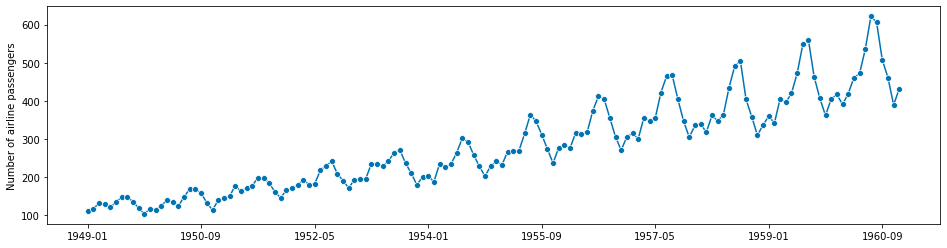

In [2]:
y = get_data('airline', verbose=False)
_ = plot_series(y)

## Setup PyCaret Time Series Experiment 

* Based on business needs and good data science principles
  - e.g. Interested in forecasting 12 months out
  - Use 3 folds to do any cross-validation
  
* **Important arguments to setup**
  - `fh` - forecast-horizon
  - `folds` - number of cross validation folds to use
  - `fold_strategy` - 'sliding' or 'expanding'
  - `seasonal_period`: Inferred using index; can be explicitly set

In [3]:
exp = TimeSeriesExperiment()
exp.setup(data=y, fh=12, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(144, 1)"
2,Missing Values,False
3,Transformed Train Set,"(132,)"
4,Transformed Test Set,"(12,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,CPU Jobs,-1
8,Use GPU,False
9,Log Experiment,False


## Looking under the hood

### Train/Test Split

Internally split: Keep len(fh) as test set

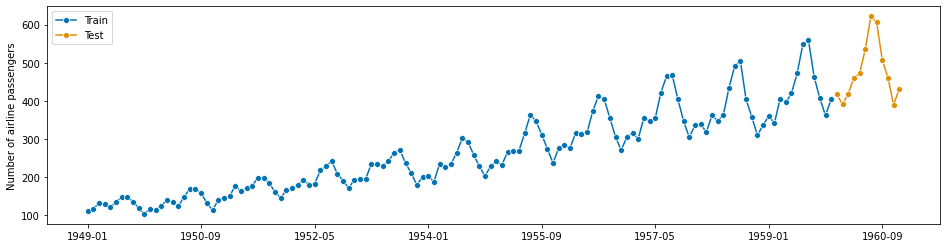

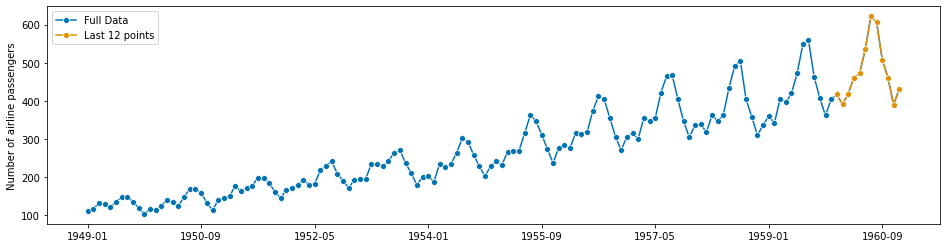

In [4]:
y_train = exp.get_config("y_train")
y_test = exp.get_config("y_test")

_ = plot_series(y_train, y_test, labels=['Train', 'Test'])
_ = plot_series(y, y[-12:], labels=['Full Data', 'Last 12 points'])

### Seasonality

Used to define the internal grid for tuning models, etc.

In [5]:
print(f"\nSeasonality Present: {exp.get_config('seasonality_present')}")
print(f"Seasonal Period: {exp.get_config('seasonal_period')}")


Seasonality Present: True
Seasonal Period: 12


### Cross Validation / Fold Generation

* Uses `sktime`'s `ExpandingWindowSplitter` and `SlidingWindowSplitter` to generate folds.
* Arguments for the splitters are determined based on inputs to `exp.setup`

**Example** (using `sktime=0.5.3`):
  - Total Data Points = 144
  - Train Data Points = 144 - 12 = 132
  - Folds Requested = 3 (Default)
  - Type = Expanding (Default)
  - Initial Window = Computed (132 - 3 * 12 = 96)
  - Step Size = Window Length = Length of Forecast Horizon = 12

In [6]:
print(f"\nFold Generator: {exp.get_config('fold_generator')}")
print(f"  - Fold Generator Horizon: {exp.get_config('fold_generator').fh}")
print(f"  - Fold Generator Initial Window: {exp.get_config('fold_generator').initial_window}")
print(f"  - Fold Generator Step Length: {exp.get_config('fold_generator').step_length}")
print(f"  - Fold Generator Window Length: {exp.get_config('fold_generator').window_length}")


Fold Generator: <sktime.forecasting.model_selection._split.ExpandingWindowSplitter object at 0x000001E5800A4688>
  - Fold Generator Horizon: [ 1  2  3  4  5  6  7  8  9 10 11 12]
  - Fold Generator Initial Window: 96
  - Fold Generator Step Length: 12
  - Fold Generator Window Length: 12


## Looking Under the Hood & Customizing the Flow

### Model Definitions

- `Args` - Used in `create_model`
- `Tune Grid` - Used for fixed grid search
- `Tune Distributions` - Used in random grid search

In [7]:
exp.models(internal=True).head()

,Name,Reference,Turbo,Special,Class,Equality,Args,Tune Grid,Tune Distributions,Tune Args,GPU Enabled,Tunable Class
ID,,,,,,,,,,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True,False,<class 'sktime.forecasting.naive.NaiveForecast...,<function ModelContainer.__init__.<locals>.<la...,{},"{'strategy': ['last', 'mean', 'drift'], 'sp': ...",{'strategy': CategoricalDistribution(values=['...,{},False,None
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True,False,<class 'sktime.forecasting.naive.NaiveForecast...,<function ModelContainer.__init__.<locals>.<la...,{'sp': 12},"{'strategy': ['last', 'mean', 'drift'], 'sp': ...",{'strategy': CategoricalDistribution(values=['...,{},False,None
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True,False,<class 'sktime.forecasting.trend.PolynomialTre...,<function ModelContainer.__init__.<locals>.<la...,{},"{'degree': [1, 2, 3, 4, 5], 'with_intercept': ...","{'degree': IntUniformDistribution(lower=1, upp...",{},False,None
arima,ARIMA,sktime.forecasting.arima.ARIMA,True,False,<class 'sktime.forecasting.arima.ARIMA'>,<function ModelContainer.__init__.<locals>.<la...,"{'seasonal_order': (0, 1, 0, 12), 'n_jobs': -1}","{'order': [(0, 0, 1), (0, 0, 0)], 'seasonal_or...","{'order': CategoricalDistribution(values=[(0, ...",{},False,None
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True,False,<class 'sktime.forecasting.arima.AutoARIMA'>,<function ModelContainer.__init__.<locals>.<la...,"{'sp': 12, 'random_state': 42, 'suppress_warni...","{'max_p': [12], 'max_q': [12], 'max_order': [N...","{'sp': CategoricalDistribution(values=[12, 24]...",{},False,None


### Create Model

#### Default

In [8]:
model = exp.create_model("naive")
model

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,63.4167,6967.9167,0.1549,0.1766,-1.2681
1,1957-12,52.3333,5842.1667,0.1205,0.1351,-0.5305
2,1958-12,91.3333,12811.6667,0.1954,0.2259,-1.8662
Mean,nan,69.0278,8540.5833,0.1569,0.1792,-1.2216
SD,nan,16.4086,3054.8806,0.0306,0.0371,0.5463


NaiveForecaster(sp=1, strategy='last', window_length=None)

#### Manually specify model arguments

In [9]:
model = exp.create_model("naive", strategy='drift')
model

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,54.5675,5389.9425,0.1332,0.1489,-0.7545
1,1957-12,47.2819,4743.9295,0.1108,0.1205,-0.2428
2,1958-12,79.0434,10522.4321,0.1667,0.1909,-1.3541
Mean,nan,60.2976,6885.4347,0.1369,0.1534,-0.7838
SD,nan,13.5849,2585.2332,0.0230,0.0289,0.4542


NaiveForecaster(sp=1, strategy='drift', window_length=None)

#### Change number of folds

In [10]:
model = exp.create_model("naive", fold=5)
model

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1954-12,55.0000,4652.8333,0.1782,0.2038,-1.8583
1,1955-12,51.5833,4624.9167,0.1424,0.1605,-1.2025
2,1956-12,63.4167,6967.9167,0.1549,0.1766,-1.2681
3,1957-12,52.3333,5842.1667,0.1205,0.1351,-0.5305
4,1958-12,91.3333,12811.6667,0.1954,0.2259,-1.8662
Mean,nan,62.7333,6979.9000,0.1583,0.1804,-1.3451
SD,nan,14.9045,3041.8833,0.0263,0.0319,0.4949


NaiveForecaster(sp=1, strategy='last', window_length=None)

### Tune Model

#### Returning the Tuner

In [11]:
tuned_model, tuner = exp.tune_model(model, return_tuner=True)

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,54.5675,5389.9425,0.1332,0.1489,-0.7545
1,1957-12,47.2819,4743.9295,0.1108,0.1205,-0.2428
2,1958-12,79.0434,10522.4321,0.1667,0.1909,-1.3541
Mean,nan,60.2976,6885.4347,0.1369,0.1534,-0.7838
SD,nan,13.5849,2585.2332,0.0230,0.0289,0.4542


#### Check the results of the tuner

In [12]:
# Grid Results
pd.DataFrame(tuner.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_window_length,param_strategy,param_sp,params,split0_test_smape,split1_test_smape,split2_test_smape,mean_test_smape,std_test_smape,rank_test_smape
0,0.000332,0.000469,0.001995,6.257699e-07,None,last,1,"{'window_length': None, 'strategy': 'last', 's...",0.176606,0.135060,0.225903,0.179190,0.037132,2
1,0.000666,0.000471,0.001653,9.473634e-04,None,mean,1,"{'window_length': None, 'strategy': 'mean', 's...",0.518785,0.476298,0.527557,0.507547,0.022385,3
2,0.000000,0.000000,0.001652,4.822561e-04,None,drift,1,"{'window_length': None, 'strategy': 'drift', '...",0.148905,0.120522,0.190900,0.153442,0.028910,1


In [13]:
# Best Hyperparameters
pprint(tuner.best_params_)

{'sp': 1, 'strategy': 'drift', 'window_length': None}


#### Defining a Custom Grid

In [14]:
my_grid = {
    'sp': [12],
    'strategy': ['last', 'mean', 'drift'],
    'window_length': [12, 24, None]
}
my_grid

{'sp': [12],
 'strategy': ['last', 'mean', 'drift'],
 'window_length': [12, 24, None]}

In [15]:
tuned_model = exp.tune_model(model, custom_grid=my_grid)

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,40.1667,1720.1667,0.1076,0.1138,0.4401
1,1957-12,12.5833,289.4167,0.0314,0.0322,0.9242
2,1958-12,47.3333,2426.0000,0.1106,0.1176,0.4573
Mean,nan,33.3611,1478.5278,0.0832,0.0879,0.6072
SD,nan,14.9806,888.8341,0.0367,0.0394,0.2243


**The performance improved over the original tuning (we essentially converted the naive model to a seasonal naive model with this new grid)**

## Prediction Intervals

Available for some models only

In [16]:
model = exp.create_model("theta")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,57.5799,5883.9192,0.1406,0.1582,-0.9153
1,1957-12,48.6352,5040.6939,0.1131,0.1244,-0.3205
2,1958-12,82.1049,11072.6778,0.1738,0.1995,-1.4772
Mean,nan,62.7733,7332.4303,0.1425,0.1607,-0.9043
SD,nan,14.1488,2667.0640,0.0248,0.0307,0.4723


In [17]:
exp.predict_model(model, return_pred_int=True)

,Model,MAE,RMSE,MAPE,SMAPE,R2
0,Theta Forecaster,69.7290,96.1663,0.1306,0.1462,-0.6695


,y_pred,lower,upper
1960-01,407.3563,320.5866,494.1260
1960-02,408.6381,302.4562,514.8201
1960-03,409.9200,287.3630,532.4770
1960-04,411.2019,274.2133,548.1904
1960-05,412.4837,262.4455,562.5220
1960-06,413.7656,251.7252,575.8060
1960-07,415.0474,241.8345,588.2604
1960-08,416.3293,232.6221,600.0365
1960-09,417.6111,223.9776,611.2447
1960-10,418.8930,215.8177,621.9683


**Models that do not provide a predicton interval simply return NA values**

In [18]:
model = exp.create_model("naive")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,63.4167,6967.9167,0.1549,0.1766,-1.2681
1,1957-12,52.3333,5842.1667,0.1205,0.1351,-0.5305
2,1958-12,91.3333,12811.6667,0.1954,0.2259,-1.8662
Mean,nan,69.0278,8540.5833,0.1569,0.1792,-1.2216
SD,nan,16.4086,3054.8806,0.0306,0.0371,0.5463


In [19]:
exp.predict_model(model, return_pred_int=True)

,Model,MAE,RMSE,MAPE,SMAPE,R2
0,Naive Forecaster,76.0000,102.9765,0.1425,0.1612,-0.9143


,y_pred,lower,upper
1960-01,405.0,NaN,NaN
1960-02,405.0,NaN,NaN
1960-03,405.0,NaN,NaN
1960-04,405.0,NaN,NaN
1960-05,405.0,NaN,NaN
1960-06,405.0,NaN,NaN
1960-07,405.0,NaN,NaN
1960-08,405.0,NaN,NaN
1960-09,405.0,NaN,NaN
1960-10,405.0,NaN,NaN
